In [1]:
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb#:~:text=Binary%20Classification%20Using%20Convolution%20Neural%20Network%20(CNN)%20Model,-Mayank%20Verma&text=Binary%20classification%20is%20used%20in,like%20Color%2C%20weight%2C%20etc.
# https://www.kaggle.com/code/mostafizur1997/binary-image-classification-using-cnn
import rasterio
import numpy as np
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [2]:
input_sar_image_path  = "../input/eaton_s1_ready.tif"
input_label_image_path="input/eaton_dnbr_label.tif"

In [3]:
# Load input image (tif)
with rasterio.open(input_sar_image_path) as src:
    input_image = src.read([1, 2, 3,4])  # Read all RGB bands (assuming 3 bands)
    input_image = np.moveaxis(input_image, 0, -1)  # Shape: (height, width, channels)

# Load label image (tif)
with rasterio.open(input_label_image_path) as src:
    label_image = src.read(1)  # Assuming the label is a single band
    meta = src.meta.copy()

In [4]:
patch_size = 32  # Size of each patch (64x64 pixels)
stride = 14  # Stride for moving the patch across the image
# patch_size = 64  # Size of each patch (64x64 pixels)
# stride = 32  # Stride for moving the patch across the image

def extract_patches(image, label, patch_size, stride):
    patches = []
    label_patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size, stride):
        for x in range(0, width - patch_size, stride):
            patch = image[y:y + patch_size, x:x + patch_size, :]
            label_patch = label[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            label_patches.append(label_patch)
    return np.array(patches), np.array(label_patches)

# Extract patches from both input image and label image
X_patches, y_patches = extract_patches(input_image, label_image, patch_size, stride)

print(X_patches.shape)


(10736, 32, 32, 4)


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_patches, y_patches, test_size=0.50, random_state=42)
# Split the remaining data into validation and testing sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_train = np.expand_dims(y_train, axis=-1)
y_val=np.expand_dims(y_val, axis=-1)
y_test=np.expand_dims(y_test, axis=-1)
print(f"Train data: {X_train.shape}")
print(f"train label data: {y_train.shape}")

print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")


Train data: (5368, 32, 32, 4)
train label data: (5368, 32, 32, 1)
Validation data: (2684, 32, 32, 4)
Test data: (2684, 32, 32, 4)


In [6]:
# from tensorflow.keras.layers import Input, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization


# def unet_model(input_shape=(patch_size, patch_size, 4)):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

#     # Bottleneck
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

#     # Decoder (Upsampling + Skip Connections)
#     up1 = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(conv4)
#     concat1 = concatenate([up1, conv3])

#     up2 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(concat1)
#     concat2 = concatenate([up2, conv2])

#     up3 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(concat2)
#     concat3 = concatenate([up3, conv1])

#     outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat3)

#     model = Model(inputs, outputs)
#     return model

# # Build U-Net model
# model = unet_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()


In [7]:
# from tensorflow.keras.layers import Input, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization


# def unet_model(input_shape=(patch_size, patch_size, 4)):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

#     # Bottleneck
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

#     # Decoder (Upsampling + Skip Connections)
#     up1 = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(conv4)
#     concat1 = concatenate([up1, conv3])

#     up2 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(concat1)
#     concat2 = concatenate([up2, conv2])

#     up3 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(concat2)
#     concat3 = concatenate([up3, conv1])

#     outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat3)

#     model = Model(inputs, outputs)
#     return model

# # Build U-Net model
# model = unet_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()

In [6]:


def unet_model(input_shape=(patch_size, patch_size, 4)):
    inputs = Input(input_shape)

    # Encoder (Reduced Depth)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder (Less Aggressive Upsampling)
    up1 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(conv3)
    concat1 = concatenate([up1, conv2])

    up2 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(concat1)
    concat2 = concatenate([up2, conv1])

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat2)

    model = Model(inputs, outputs)
    return model

# Build and compile the U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Build U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │     73,792 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │     36,896 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 1) │         65 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,289 (798.00 KB)

 Trainable params: 204,289 (798.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7659 - loss: 0.5276 - val_accuracy: 0.8625 - val_loss: 0.3649
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8610 - loss: 0.3600 - val_accuracy: 0.8746 - val_loss: 0.3207
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8712 - loss: 0.3261 - val_accuracy: 0.8859 - val_loss: 0.2917
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8786 - loss: 0.3096 - val_accuracy: 0.8924 - val_loss: 0.2840
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8850 - loss: 0.2930 - val_accuracy: 0.9010 - val_loss: 0.2586
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9043 - loss: 0.2499 - val_accuracy: 0.9097 - val_loss: 0.2376
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9048 - loss: 0.2500 - val_accuracy: 0.9096 - val_loss: 0.2474
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9074 - loss: 0.2448 - val_accu

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")



84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9164 - loss: 0.2217
Test Accuracy: 0.9141461849212646


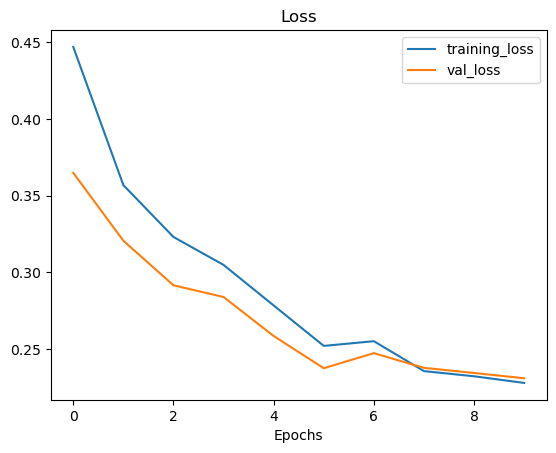

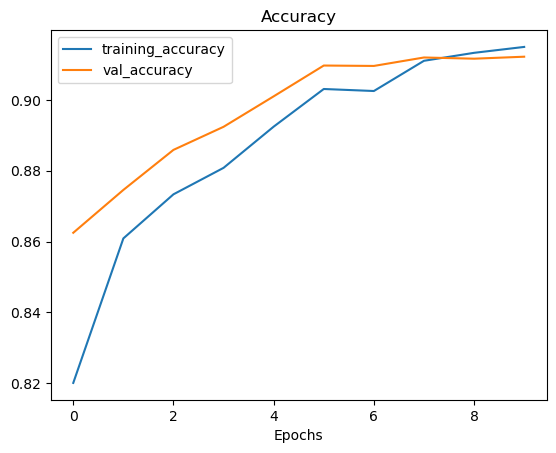

In [11]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(history)

In [ ]:
# import numpy as np
# from tensorflow.image import extract_patches

# def extract_image_patches(image, patch_size=(patch_size, patch_size), stride=stride):
#     """
#     Extracts patches from an image.
    
#     Args:
#     - image (numpy array): Input image of shape (H, W, C)
#     - patch_size (tuple): Size of each patch (height, width)
#     - stride (int): Step size for moving window
    
#     Returns:
#     - patches (numpy array): Extracted patches (num_patches, patch_size, patch_size, C)
#     """
#     H, W, C = image.shape
#     patch_H, patch_W = patch_size

#     # Compute number of patches
#     num_patches_H = (H - patch_H) // stride + 1
#     num_patches_W = (W - patch_W) // stride + 1

#     patches = []

#     for i in range(0, H - patch_H + 1, stride):
#         for j in range(0, W - patch_W + 1, stride):
#             patch = image[i:i + patch_H, j:j + patch_W, :]
#             patches.append(patch)

#     return np.array(patches)



In [ ]:
# X_patches = extract_image_patches(input_image, patch_size=(patch_size, patch_size), stride=32)

# print("Extracted X_patches shape:", X_patches.shape)

Extracted X_patches shape: (2106, 32, 32, 4)


In [ ]:
# # Predict on new data (e.g., test set or validation set)
# predictions = model.predict(X_patches)
# binary_predictions = (predictions > 0.5).astype(np.uint8)
# # class_predictions = np.argmax(binary_predictions, axis=-1)  # Shape: (1409, 64, 64)
# print(binary_predictions.shape)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(2106, 32, 32, 1)


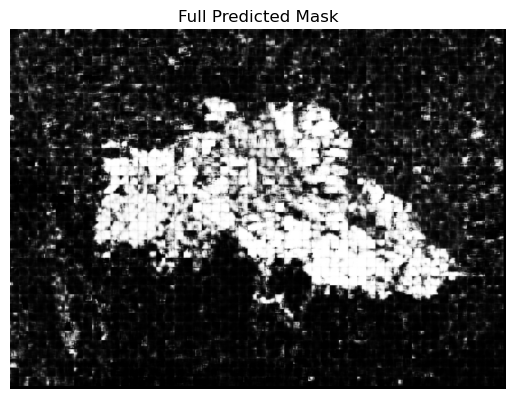

In [ ]:
# import matplotlib.pyplot as plt
# def reconstruct_from_patches(patches, image_size, patch_size=(patch_size, patch_size), stride=32):
#     H, W = image_size
#     patch_H, patch_W = patch_size
#     full_image = np.zeros((H, W, 1))  # Assuming single-channel output

#     idx = 0
#     for i in range(0, H - patch_H + 1, stride):
#         for j in range(0, W - patch_W + 1, stride):
#             full_image[i:i + patch_H, j:j + patch_W, :] = patches[idx]
#             idx += 1

#     return full_image

# # Reconstruct full predicted mask
# predicted_mask = reconstruct_from_patches(predictions, input_image.shape[:2])

# # Visualize the final prediction
# plt.imshow(predicted_mask.squeeze(), cmap='gray')
# plt.title('Full Predicted Mask')
# plt.axis('off')
# plt.show()


In [ ]:
# with rasterio.open("image_reconstruct.tiff", 'w') as dest:
#         # clipped_data = dataset.read(i+1, window=window)
#         dest.write(predicted_mask, 1)
# import tifffile as tiff
# # Save as TIFF
# tiff.imwrite("predicted_mask.tiff", predicted_mask.astype(np.float32))

In [18]:
# Define metadata for rasterio
# output_image_path = "predicted_mask.tif"

# meta = {
#     "driver": "GTiff",
#     "dtype": predicted_mask.dtype,
#     "count": 1,  # Single-band image
#     "height": predicted_mask.shape[0],
#     "width": predicted_mask.shape[1],
#     "crs": "EPSG:4326",  # Change CRS if needed
#     # "transform": from_origin(0, 0, 1, 1)  # Modify transform if georeferenced data
# }

# Save as TIFF with metadata
# with rasterio.open(output_image_path, 'w', **meta) as dest:
#     dest.write(predicted_mask, 1)  # Write the image as band 1

# print(f"TIFF file saved with metadata at {output_image_path}")

In [19]:
# from tensorflow import keras
# from tensorflow.keras import datasets, layers, models
# from keras.models import Sequential
# # from keras.layers.core import Flatten, Dense, Dropout
# # from keras.layers.convolutional import Convolution2D, MaxPooling2D
# #creating convolutional model

# model = models.Sequential()

# model.add(layers.Conv2D(64, (3, 3), activation='relu',
#                         input_shape=(363, 358, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
# model.add(layers.Dense(2, activation='softmax'))

# model.summary()

In [12]:
model.save("model/unet_model.h5")
